In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy

In [5]:
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [16]:
#Construct an ImageDataGenerator object:
DIRECTORY = "Covid19-dataset/train"
CLASS_MODE = "categorical"
COLOR_MODE = "grayscale"
TARGET_SIZE = (256,256)
BATCH_SIZE = 32

In [17]:
training_data_generator = ImageDataGenerator(rescale=1.0/255,

#Randomly increase or decrease the size of the image by up to 10%
zoom_range=0.1, 

#Randomly rotate the image between -25,25 degrees
rotation_range=25, 

#Shift the image along its width by up to +/- 5%
width_shift_range=0.05, 

#Shift the image along its height by up to +/- 5%
height_shift_range=0.05,

)

In [18]:
validation_data_generator = ImageDataGenerator()

training_iterator = training_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical',color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='training')

training_iterator.next()

print("\nLoading validation data...")


validation_iterator = validation_data_generator.flow_from_directory(DIRECTORY,class_mode='categorical', color_mode='grayscale',batch_size=BATCH_SIZE)#, subset='validation')

#Print its attributes:
# print(training_data_generator.__dict__)


print("\nBuilding model...")

Found 251 images belonging to 3 classes.

Loading validation data...
Found 251 images belonging to 3 classes.

Building model...


In [33]:
def design_model(training_data):
    # sequential model
    model = Sequential()
    # add input layer with grayscale image shape
    model.add(tf.keras.Input(shape=(256, 256, 1)))
    # convolutional hidden layers with relu functions
    # maxpooling layers and dropout layers as well
    model.add(layers.Conv2D(5, 5, strides=3, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.1))
    model.add(layers.Conv2D(3, 3, strides=1, activation="relu")) 
    model.add(layers.MaxPooling2D(
        pool_size=(2, 2), strides=(2,2)))
    model.add(layers.Dropout(0.2))
    # experimenting with extra layesr
    model.add(tf.keras.layers.Conv2D(3, 3, strides=1, activation="relu"))
    model.add(tf.keras.layers.Conv2D(1, 1, strides=1, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(layers.Flatten())
    # output layer with softmax activation function
    model.add(layers.Dense(3,activation="softmax"))
    # compile model with Adam optimizer
    # loss function is categorical crossentropy
    # metrics are categorical accuracy and AUC
    print("\nCompiling model...")
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],)
    # summarize model
    model.summary()
    return model

In [34]:
# use model function
model = design_model(training_iterator)


Compiling model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 84, 84, 5)         130       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 42, 42, 5)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 42, 42, 5)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 3)         138       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 3)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 20, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None

In [35]:
# early stopping implementation
es = EarlyStopping(monitor='val_auc', mode='min', verbose=1, patience=20)

In [36]:
print("\nTraining model...")
# fit the model with 10 ephochs and early stopping
history =model.fit(
        training_iterator,
        steps_per_epoch=training_iterator.samples/BATCH_SIZE, epochs=5,
        validation_data=validation_iterator,
        validation_steps=validation_iterator.samples/BATCH_SIZE,
        callbacks=[es])


Training model...
Train for 7.84375 steps, validate for 7.84375 steps
Epoch 1/5
8/7 [==============================] - 8s 975ms/step - loss: 1.0991 - categorical_accuracy: 0.3586 - auc_3: 0.5082 - val_loss: 1.7971 - val_categorical_accuracy: 0.4183 - val_auc_3: 0.5654
Epoch 2/5
8/7 [==============================] - 6s 703ms/step - loss: 1.0868 - categorical_accuracy: 0.4422 - auc_3: 0.5765 - val_loss: 1.9731 - val_categorical_accuracy: 0.5100 - val_auc_3: 0.5882
Epoch 3/5
8/7 [==============================] - 5s 624ms/step - loss: 1.0767 - categorical_accuracy: 0.4422 - auc_3: 0.5761 - val_loss: 2.1979 - val_categorical_accuracy: 0.4741 - val_auc_3: 0.5674
Epoch 4/5
8/7 [==============================] - 5s 673ms/step - loss: 1.0693 - categorical_accuracy: 0.4422 - auc_3: 0.6112 - val_loss: 2.6693 - val_categorical_accuracy: 0.4582 - val_auc_3: 0.5674
Epoch 5/5
8/7 [==============================] - 5s 598ms/step - loss: 1.0629 - categorical_accuracy: 0.4422 - auc_3: 0.6445 - val_lo

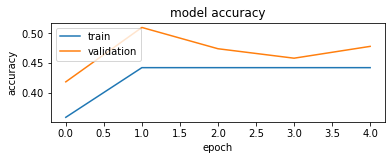

In [37]:
# plotting categorical and validation accuracy over epochs
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')

In [39]:
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predictions = model.predict(validation_iterator, steps=test_steps_per_epoch)
test_steps_per_epoch = numpy.math.ceil(validation_iterator.samples / validation_iterator.batch_size)
predicted_classes = numpy.argmax(predictions, axis=1)
true_classes = validation_iterator.classes
class_labels = list(validation_iterator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   

cm=confusion_matrix(true_classes,predicted_classes)
print(cm)

              precision    recall  f1-score   support

       Covid       0.46      0.92      0.61       111
      Normal       0.75      0.04      0.08        70
   Pneumonia       0.36      0.13      0.19        70

    accuracy                           0.45       251
   macro avg       0.52      0.36      0.29       251
weighted avg       0.51      0.45      0.35       251

[[102   1   8]
 [ 59   3   8]
 [ 61   0   9]]
